In [61]:
from rdkit import Chem
from rdkit.Chem import rdchem
import pandas as pd

# Set display options and suppress all warnings
pd.set_option('display.max_columns', None)

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole  # Jupyter上で分子構造表示可能にする

import re
from collections import Counter

In [62]:
# 1. トリアリールアミンの例SMILESリスト
smiles_list = [
    #"N(c1ccccc1)(c2ccccc2)c3ccccc3",
    "N(c1ccccc1)(c2ccccc2)c3ccc(Cl)cc3",
    "N(c1ccccc1)(c2ccccc2)c3ccc(F)cc3",
    "N(c1ccccc1)(c2ccccc2)c3ccc(CN)cc3",
    "N(c1ccccc1)(c2ccccc2)c3ccc(OC)cc3",
    "N(c1ccccc1)(c2ccccc2)c3ccc(cc3)[N+](=O)[O-]",    # NO2
    "N(c1ccccc1)(c2ccccc2)c3ccc(cc3)C(F)(F)F",        # CF3
    "N(c1ccccc1)(c2ccccc2)c3ccc(cc3)OC(F)(F)F",       # OCF3
    "N(c1ccccc1)(c2ccccc2)c3ccc(C#N)cc3",
    "N(c1ccccc1)(c2ccccc2)c3ccc(CO)cc3",
    "N(c1ccccc1)(c2ccccc2)c3ccc(S)cc3",
    "N(c1ccccc1)(c2ccccc2)c3ccc(CC)cc3",
    "N(c1ccccc1)(c2ccccc2)c3ccc(CCl)cc3",
    "N(c1ccccc1)(c2ccccc2)c3ccc(CBr)cc3",
    "N(c1ccccc1)(c2ccccc2)c3ccc(CI)cc3",
    "N(c1ccccc1)(c2ccccc2)c3ccc(C=O)cc3",
    "N(c1ccccc1)(c2ccccc2)c3ccc(N)cc3",
    "N(c1ccccc1)(c2ccccc2)c3ccc(C)cc3",
    "N(c1ccccc1)(c2ccccc2)c3cccc4ccccc34",   # 1-naphthyl
    "N(c1ccccc1)(c2ccccc2)c3ccc4ccccc4c3",   # 2-naphthyl
    "C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC4=C(C=C3)C5=CC=CC=C5N4", # czlbazole
]

In [63]:
def normalize_dummy_atoms(smiles: str) -> str:
    """
    ダミー原子の表記を必ず [*] に統一する
    - [6*], [7*], なども [*] に置換
    - [*:1], [*:2] など番号付きも [*] に置換
    """
    smiles = re.sub(r"\[\d*\*\]", "[*]", smiles)
    smiles = re.sub(r"\[\*:[0-9]+\]", "[*]", smiles)
    smiles = re.sub(r"(?<!\[)\*(?!\])", "[*]", smiles)
    return smiles


In [64]:
def extract_substituents_with_attachment(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []

    subs = []
    for atom in mol.GetAtoms():
        # 三級アミンNのみ
        if atom.GetSymbol() == "N" and atom.GetDegree() == 3:
            for bond in atom.GetBonds():
                bond_idx = bond.GetIdx()

                # 結合を切断
                emol = Chem.FragmentOnBonds(mol, [bond_idx], addDummies=True)
                frags = Chem.GetMolFrags(emol, asMols=True, sanitizeFrags=True)

                for f in frags:
                    atoms = f.GetAtoms()
                    # ダミー原子を含むか？
                    if any(a.GetAtomicNum() == 0 for a in atoms):
                        # そのダミー原子がNにつながっていなければ置換基
                        keep = True
                        for a in atoms:
                            if a.GetAtomicNum() == 0:  # dummy
                                if any(n.GetSymbol() == "N" for n in a.GetNeighbors()):
                                    keep = False
                        if keep:
                            smi = Chem.MolToSmiles(f, canonical=True)
                            smi = normalize_dummy_atoms(smi)  # ← 正規化を必ず通す
                            subs.append(smi)
            break
    return subs


In [65]:
# --- すべての分子から抽出 ---
all_subs = []
subs_per_mol = []
for smi in smiles_list:
    subs = extract_substituents_with_attachment(smi)
    subs_per_mol.append(subs)
    all_subs.extend(subs)

In [66]:
# --- ユニーク化 + FLラベル ---
unique_subs = sorted(set(all_subs))
fl_map = {smi: f"FL-{i+1}" for i, smi in enumerate(unique_subs)}


In [ ]:
# --- フィンガープリント化 カウントVer.---
fp_data = []
for smi, subs in zip(smiles_list, subs_per_mol):
    counts = Counter(subs)
    row = [counts.get(sub, 0) for sub in unique_subs]
    fp_data.append(row)

In [ ]:
"""
# --- フィンガープリント化 0/1 ver.---
fp_data = []
for subs in subs_per_mol:
    row = {fl: 0 for fl in fl_map.values()}
    for s in subs:
        row[fl_map[s]] = 1
    fp_data.append(row)
"""

In [68]:
df_fp = pd.DataFrame(fp_data, index=[f"Mol-{i+1}" for i in range(len(smiles_list))])
df_map = pd.DataFrame(list(fl_map.items()), columns=["Substituent_SMILES", "Feature_Label"])

print("=== 置換基対応表 ===")
print(df_map)

print("\n=== フィンガープリントDataFrame ===")
print(df_fp)


=== 置換基対応表 ===
             Substituent_SMILES Feature_Label
0              [*]c1ccc(C#N)cc1          FL-1
1         [*]c1ccc(C(F)(F)F)cc1          FL-2
2                [*]c1ccc(C)cc1          FL-3
3              [*]c1ccc(C=O)cc1          FL-4
4              [*]c1ccc(CBr)cc1          FL-5
5               [*]c1ccc(CC)cc1          FL-6
6              [*]c1ccc(CCl)cc1          FL-7
7               [*]c1ccc(CI)cc1          FL-8
8               [*]c1ccc(CN)cc1          FL-9
9               [*]c1ccc(CO)cc1         FL-10
10              [*]c1ccc(Cl)cc1         FL-11
11               [*]c1ccc(F)cc1         FL-12
12               [*]c1ccc(N)cc1         FL-13
13       [*]c1ccc(OC(F)(F)F)cc1         FL-14
14              [*]c1ccc(OC)cc1         FL-15
15               [*]c1ccc(S)cc1         FL-16
16    [*]c1ccc([N+](=O)[O-])cc1         FL-17
17  [*]c1ccc2c(c1)[nH]c1ccccc12         FL-18
18            [*]c1ccc2ccccc2c1         FL-19
19            [*]c1cccc2ccccc12         FL-20
20                 

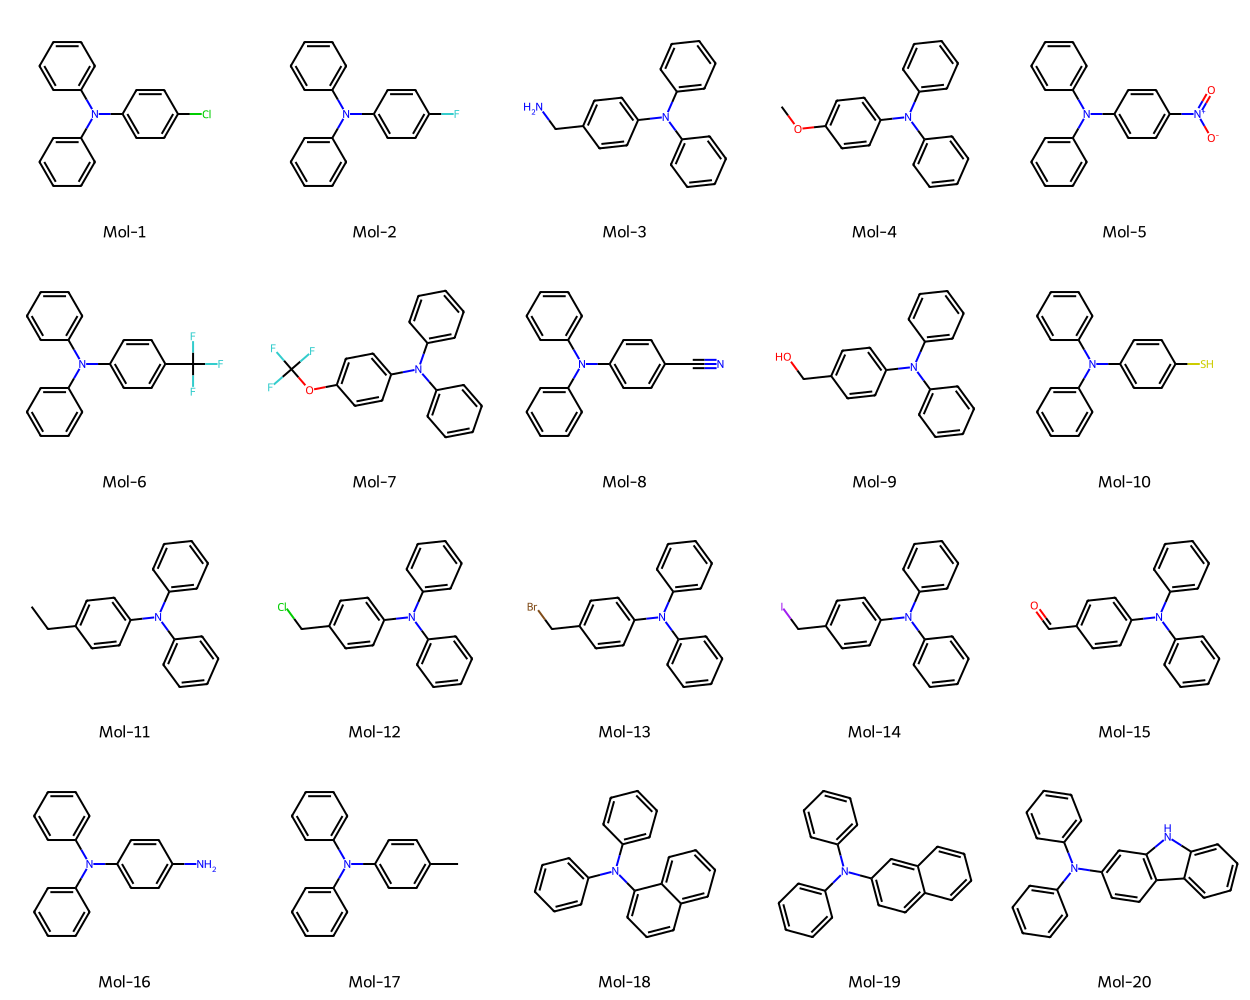

In [69]:
# 元分子
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
img_mols = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(250,250),
                                legends=[f"Mol-{i+1}" for i in range(len(mols))])
display(img_mols)

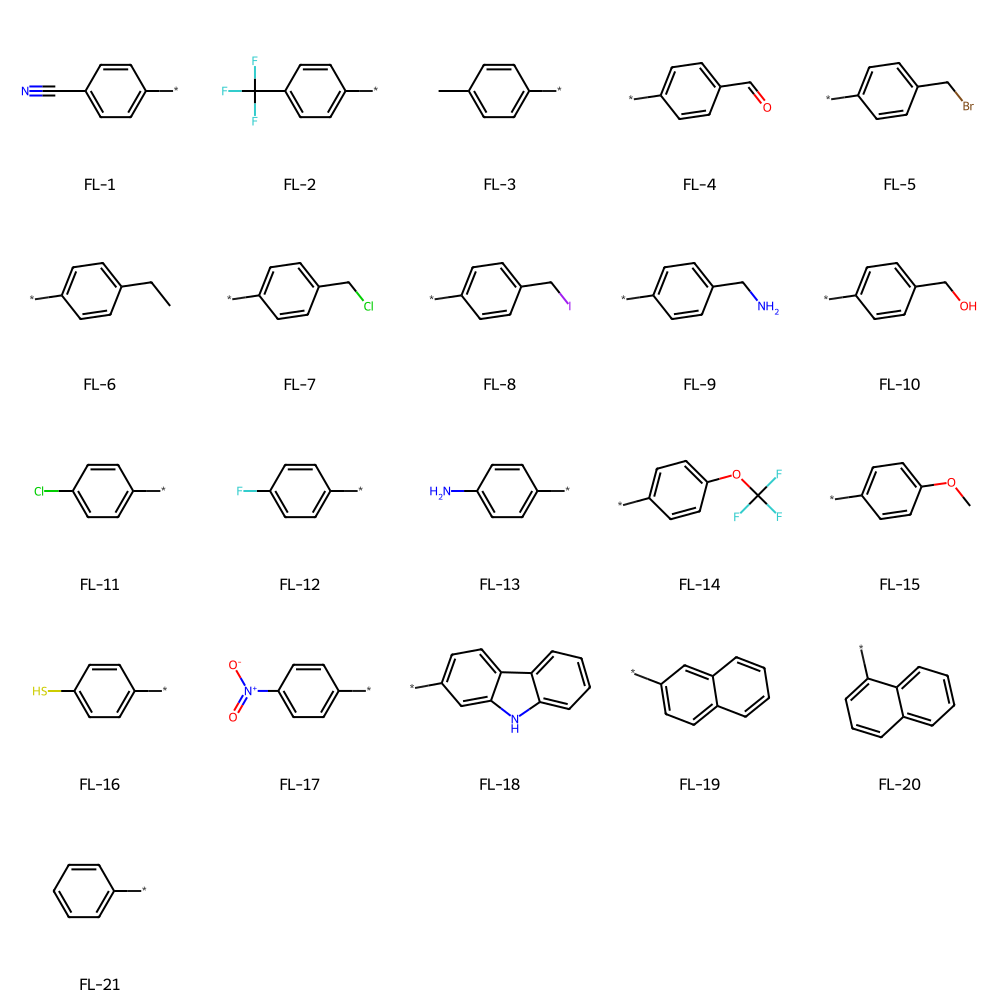

In [70]:
# 置換基（結合点[*]を含む）
subs_mols = [Chem.MolFromSmiles(s) for s in unique_subs]
img_subs = Draw.MolsToGridImage(subs_mols, molsPerRow=5, subImgSize=(200,200),
                                legends=[fl_map[s] for s in unique_subs])
display(img_subs)